### OKCoders: Data Analytics Final Project
#### *How Much Does a Strikeout Cost?*

---

#### Background Information

Prompt - use the Lahman database (2016 edition) to determine how much a strikeout costs. Analysis was restricted to every pitcher for every team from 2007-2016 who have played at least 10 games. After determining the cost per strikeout for each team-year combination, analyze a few factors and build a regression model that would help determine a attributes to look for in fielding a pitching staff. The few candidate elements analyzed were:
+ **weighted average career age of the pitching bullpen**
+ **weighted average age of the pitching bullpen**
+ **probability of a walk for a given at bat for that team.** 

Analysis article below:

---

Import needed libraries and do a quick look at the 4 main tables used for extracting data and performing analysis - *Master*, *Pitching*, *Teams* and *Salaries*.

In [1]:
import pandas as pd
import sqlite3
from sklearn.linear_model import LinearRegression

In [2]:
lah_db = sqlite3.connect("lahman2016.db") #lahman2016 data strectches from 2007-2016

In [3]:
master = pd.read_sql("SELECT * FROM Master", con = lah_db) #pulls in tables from SQL
pitching = pd.read_sql("SELECT * FROM Pitching", con = lah_db)
teams = pd.read_sql("SELECT * FROM Teams", con = lah_db)
salaries = pd.read_sql("SELECT * FROM Salaries", con = lah_db)

In [4]:
master.head() #looks at the top 5 rows

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,...,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
0,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,Aardsma,David Allan,215.0,75.0,R,R,2004-04-06,2015-08-23,aardd001,aardsda01
1,aaronha01,1934.0,2.0,5.0,USA,AL,Mobile,NaN,NaN,NaN,...,Aaron,Henry Louis,180.0,72.0,R,R,1954-04-13,1976-10-03,aaroh101,aaronha01
2,aaronto01,1939.0,8.0,5.0,USA,AL,Mobile,1984.0,8.0,16.0,...,Aaron,Tommie Lee,190.0,75.0,R,R,1962-04-10,1971-09-26,aarot101,aaronto01
3,aasedo01,1954.0,9.0,8.0,USA,CA,Orange,NaN,NaN,NaN,...,Aase,Donald William,190.0,75.0,R,R,1977-07-26,1990-10-03,aased001,aasedo01
4,abadan01,1972.0,8.0,25.0,USA,FL,Palm Beach,NaN,NaN,NaN,...,Abad,Fausto Andres,184.0,73.0,L,L,2001-09-10,2006-04-13,abada001,abadan01


In [5]:
pitching.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,aardsda01,2004,1,SFN,NL,1,0,11,0,0,...,0.0,0.0,2.0,0,61.0,5.0,8,0.0,1.0,1.0
1,aardsda01,2006,1,CHN,NL,3,0,45,0,0,...,0.0,1.0,1.0,0,225.0,9.0,25,1.0,3.0,2.0
2,aardsda01,2007,1,CHA,AL,2,1,25,0,0,...,3.0,2.0,1.0,0,151.0,7.0,24,2.0,1.0,1.0
3,aardsda01,2008,1,BOS,AL,4,2,47,0,0,...,2.0,3.0,5.0,0,228.0,7.0,32,3.0,2.0,4.0
4,aardsda01,2009,1,SEA,AL,3,6,73,0,0,...,3.0,2.0,0.0,0,296.0,53.0,23,2.0,1.0,2.0


In [6]:
teams.head()

,yearID,lgID,teamID,franchID,divID,Rank,G,Ghome,W,L,...,DP,FP,name,park,attendance,BPF,PPF,teamIDBR,teamIDlahman45,teamIDretro
0,1871,NA,BS1,BNA,None,3,31,NaN,20,10,...,NaN,0.838,Boston Red Stockings,South End Grounds I,NaN,103,98,BOS,BS1,BS1
1,1871,NA,CH1,CNA,None,2,28,NaN,19,9,...,NaN,0.829,Chicago White Stockings,Union Base-Ball Grounds,NaN,104,102,CHI,CH1,CH1
2,1871,NA,CL1,CFC,None,8,29,NaN,10,19,...,NaN,0.814,Cleveland Forest Citys,National Association Grounds,NaN,96,100,CLE,CL1,CL1
3,1871,NA,FW1,KEK,None,7,19,NaN,7,12,...,NaN,0.803,Fort Wayne Kekiongas,Hamilton Field,NaN,101,107,KEK,FW1,FW1
4,1871,NA,NY2,NNA,None,5,33,NaN,16,17,...,NaN,0.839,New York Mutuals,Union Grounds (Brooklyn),NaN,90,88,NYU,NY2,NY2


In [7]:
salaries.head()

,yearID,teamID,lgID,playerID,salary
0,1985,ATL,NL,barkele01,870000.0
1,1985,ATL,NL,bedrost01,550000.0
2,1985,ATL,NL,benedbr01,545000.0
3,1985,ATL,NL,campri01,633333.0
4,1985,ATL,NL,ceronri01,625000.0


### SQL Code

SQL was used to join database tables and compute a usable dataset for python analysis. We used **INNER JOIN** between the *Pitching*, *Master* and *Salary* tables in SQL. These 3 were all pitcher specific data. We can get the `min()` of each pitcher's ***yearID*** and **INNER JOIN** this subquery onto the *Pitching* table. I labeled this new column ***first_year*** which indicated their first year pitching in the MLB. We can join this to the *Master* dataset on ***playedID*** and that to the *Salary* table based on ***playedID*** and ***yearID***.

Lastly, we can filter by pitchers who pitched 10 games or more in the years 2007-2016. Using `.read_sql()` allows us to bring in this newfound dataset.

In [8]:
querry = '''SELECT
  p.playerID,
  m.birthYear,
  fy.first_year,
  p.yearid,
  s.salary,
  p.teamID,
  p.SO as pitcher_SO, 
  p.G as games_pitched,
  p.W as pitch_wins,
  p.L as pitch_loss,
  p.BB,
  p.IBB,
  p.HBP,
  p.BAOpp
FROM Pitching as p
INNER JOIN Salaries as s
  ON s.playerID = p.playerID AND s.yearid = p.yearid
INNER JOIN Master as m
  ON m.playerID = p.playerID
INNER JOIN (
SELECT 
    playerID,
    min(yearID) as first_year
FROM Pitching
GROUP BY playerID
) as fy ON fy.playerID = p.playerID
WHERE p.yearid >= 2007
  AND p.G >= 10
ORDER BY p.playerID ASC
'''

pitcher_data = pd.read_sql(sql = querry, con = lah_db)
pitcher_data.head()

,playerID,birthYear,first_year,yearID,salary,teamID,pitcher_SO,games_pitched,pitch_wins,pitch_loss,BB,IBB,HBP,BAOpp
0,aardsda01,1981,2004,2007,387500.0,CHA,36,25,2,1,17,3,1,0.300
1,aardsda01,1981,2004,2008,403250.0,BOS,49,47,4,2,35,2,5,0.268
2,aardsda01,1981,2004,2009,419000.0,SEA,80,73,3,6,34,3,0,0.190
3,aardsda01,1981,2004,2010,2750000.0,SEA,49,53,0,6,25,5,2,0.198
4,abadfe01,1985,2010,2011,418000.0,HOU,15,29,1,4,9,0,1,0.326


### Merging and Calculations

Each pitcher's current age per ***yearID*** and career age per each ***yearID*** was determined subtracting necessary columns. 

In [9]:
#Calculate age of pitchers and their yeras in the league
pitcher_data["age"] = pitcher_data.yearID - pitcher_data.birthYear
pitcher_data["career_age"] = pitcher_data.yearID - pitcher_data.first_year #career age is firt year minus current year
pitcher_data[["playerID", "age", "first_year", "yearID", "career_age","salary", "teamID"]].head()

,playerID,age,first_year,yearID,career_age,salary,teamID
0,aardsda01,26,2004,2007,3,387500.0,CHA
1,aardsda01,27,2004,2008,4,403250.0,BOS
2,aardsda01,28,2004,2009,5,419000.0,SEA
3,aardsda01,29,2004,2010,6,2750000.0,SEA
4,abadfe01,26,2010,2011,1,418000.0,HOU


We can use place holders *new1* and *new2* to find the average of each bullpen actual age and career age for each team-year combo. This was accomplished by `.groupby()` ***teamID*** and ***yearID***. Dividing the `.sum()` by the `.count()` datasets gave the average columns for the wanted ages.

In [10]:
#Find the avg bullpen age and avg years pro per bullpen for team-year.
new1 = pitcher_data.groupby(["teamID", "yearID"]).sum()
new2 = pitcher_data.groupby(["teamID", "yearID"]).count()
new1["avg_bullpen_age"] = new1["age"]/new2["age"] #avg age of pitching bullpen for a given year
new1["avg_years_pro"] = new1["career_age"]/new2["career_age"] #avg years in league for bullpen for a given year
new1[["avg_bullpen_age", "avg_years_pro", "salary"]]

avg_bullpen_age  avg_years_pro      salary
teamID yearID                                            
ARI    2007          29.250000       5.666667  32957046.0
       2008          29.357143       5.571429  42398046.0
       2009          29.250000       5.250000  34709500.0
       2010          29.785714       5.357143  29238000.0
       2011          28.454545       4.000000  18777000.0
       2012          30.000000       4.461538  26683500.0
       2013          29.285714       4.714286  41364000.0
       2014          30.333333       5.833333  36336500.0
       2015          28.200000       4.333333  25058500.0
       2016          28.000000       4.916667  58656530.0
ATL    2007          30.384615       6.538462  31175000.0
       2008          30.214286       7.214286  53297684.0
       2009          30.300000       5.900000  46756166.0
       2010          31.416667       5.833333  49111166.0
       2011          29.583333       5.416667  38985500.0
       2012          28.466667       5.333333  27468000.0
       2013          28.923077       5.615385  32084000.0
       2014          27.750000       4.250000  32588750.0
       2015          28.200000       6.300000  37393750.0
       2016          28.909091       5.727273  18772916.0
BAL    2007          30.400000       6.700000  22333334.0
       2008          29.583333       4.916667  16826666.0
       2009          30.000000       4.538462  24937566.0
       2010          29.538462       4.769231  33027500.0
       2011          28.384615       3.846154  24909660.0
       2012          28.615385       4.384615  25306000.0
       2013          28.076923       4.307692  34343333.0
       2014          27.928571       4.285714  35986000.0
       2015          28.833333       4.916667  50254000.0
       2016          28.466667       5.066667  66800264.0
...                        ...            ...         ...
TEX    2007          28.923077       4.692308  32893645.0
       2008          29.818182       6.545455  29001242.0
       2009          29.714286       5.857143  34056562.0
       2010          28.785714       5.357143  32732040.0
       2011          30.666667       6.200000  31699950.0
       2012          31.000000       5.461538  53027600.0
       2013          28.153846       3.923077  38116800.0
       2014          29.571429       5.142857  20589827.0
       2015          28.105263       4.578947  63852900.0
       2016          29.750000       5.000000  53242370.0
TOR    2007          28.888889       5.111111  33363500.0
       2008          28.750000       5.083333  41605400.0
       2009          30.454545       5.181818  35479900.0
       2010          30.200000       5.100000  14572100.0
       2011          29.500000       5.071429  24617800.0
       2012          30.071429       5.857143  36044400.0
       2013          31.071429       6.928571  56108000.0
       2014          30.500000       5.583333  39637200.0
       2015          31.300000       8.000000  62962600.0
       2016          30.812500       7.125000  75087267.0
WAS    2007          27.909091       4.000000   9950000.0
       2008          29.272727       5.000000   8901000.0
       2009          28.454545       5.000000  11137500.0
       2010          29.444444       6.666667  16186000.0
       2011          28.500000       5.500000  21200000.0
       2012          28.142857       4.928571  35923465.0
       2013          28.461538       5.230769  52255991.0
       2014          29.916667       6.083333  57556100.0
       2015          30.583333       5.833333  90698600.0
       2016          30.714286       7.000000  81028231.0

[300 rows x 3 columns]

The cost per strikeout was determined by dividing each bullpens's (team-year combo) `.sum()` salary by their total pitched strikouts. Resetting the index allowed the dataset to be later merged in with *Teams*. The **Pittsburgh Pirates** in 2008 paid the least per strikeout for all applicable candidates at roughly **$9800** per strikeout.  

In [11]:
#Find average cost per SO per team year
new1["cost_per_SO"] = new1.salary/new1.pitcher_SO
new1[["salary", "avg_bullpen_age", "avg_years_pro", "cost_per_SO"]]
cost = (new1[["avg_bullpen_age","avg_years_pro","cost_per_SO","salary", "pitcher_SO"]]
        .sort_values("cost_per_SO")
        .reset_index()) # resetting the index allows us to use teamID later
cost.head()

,teamID,yearID,avg_bullpen_age,avg_years_pro,cost_per_SO,salary,pitcher_SO
0,PIT,2008,27.545455,3.818182,9758.597884,7377500.0,756
1,OAK,2009,27.500000,3.416667,10696.969697,8472000.0,792
2,FLO,2009,26.846154,3.538462,11426.113360,11289000.0,988
3,FLO,2008,26.750000,3.166667,11697.337963,10106500.0,864
4,WAS,2008,29.272727,5.000000,12733.905579,8901000.0,699


Merge this dataset with *Teams* where the ***teamID*** and the ***yearID*** match using `.merge()`. We can pull in necessary columns from *Teams* including team *Wins* and *Losses*, their total opponent at bats, the total walks allowed and total runs allowed. Walk probability was easily caclualted using each teams total walks allowed and dividing it by their total opponent at bats. This was labeled ***walk_prob***. The dataset is now ready for analysis/modeling containing the necessary ***cost_per_SO***, ***avg_bullpen_age***, ***avg_years_pro*** of the bullpen, and each teams bullpen's ***walk_prob***.

In [12]:
#Merge the found avg bullpen age, avg career age of bullpen, and cost per SO WITH 
#Teams and find walk probability of each team
merged = teams[["teamID","yearID", "W", "L", "AB", "BBA", "RA"]].merge(right = cost, on = ["teamID", "yearID"], how = "inner")
merged["walk_prob"] = merged.BBA/merged.AB
merged.sort_values("cost_per_SO", ascending = True).head()

,teamID,yearID,W,L,AB,BBA,RA,avg_bullpen_age,avg_years_pro,cost_per_SO,salary,pitcher_SO,walk_prob
55,PIT,2008,67,95,5628,657,884,27.545455,3.818182,9758.597884,7377500.0,756,0.116738
69,OAK,2009,75,87,5584,523,761,27.500000,3.416667,10696.969697,8472000.0,792,0.093660
79,FLO,2009,87,75,5572,601,766,26.846154,3.538462,11426.113360,11289000.0,988,0.107861
49,FLO,2008,84,77,5499,586,767,26.750000,3.166667,11697.337963,10106500.0,864,0.106565
59,WAS,2008,59,102,5491,588,825,29.272727,5.000000,12733.905579,8901000.0,699,0.107084


## Models and Analysis

The three areas of focus were money, age, and attributes of bullpen. These were analyzed and models were made to investigate which factors benefit **WINS** and **RUNS ALLOWED**.

---

### Money

Perform linear regression to see if bullpen salary and how much a team spent per strikeout impacted - 1) team's win total or 2) runs allowed by the bullpen.

In [13]:
#Salary of bullpen impact on wins
model_sal = LinearRegression()
model_sal.fit(X = merged[["salary"]], y = merged.W)
print(model_sal.score(X = merged[["salary"]], y = merged.W)) #scoring the model gives us an R^2 value

0.13342293898950697


In [14]:
#Salary of bullpen impact on runs allowed
model_sal2 = LinearRegression()
model_sal2.fit(X = merged[["salary"]], y = merged.RA)
print(model_sal2.score(X = merged[["salary"]], y = merged.RA))

0.09898568278168329


In [15]:
#Cost per SO impact on wins
model_cps = LinearRegression()
model_cps.fit(X = merged[["cost_per_SO"]], y = merged.W)
print(model_cps.score(X = merged[["cost_per_SO"]], y = merged.W))

0.029033471980284387


In [16]:
merged.plot.scatter(x="cost_per_SO", y = "W")

In [17]:
 #Cost per SO impact on runs allowed
model_cps2 = LinearRegression()
model_cps2.fit(X = merged[["cost_per_SO"]], y = merged.RA)
print(model_cps2.score(X = merged[["cost_per_SO"]], y = merged.RA))

0.008523505436621837


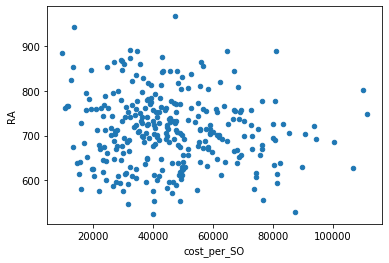

In [18]:
merged.plot.scatter(x="cost_per_SO", y = "RA")

We can see the amount someone spends per strikeout is not a determinant of wins or runs allowed. We can derive that more money thrown at a bullpen does not necessarily impact team pitching success.

---

## Age

Next, determine if the average career age of the bullpen or the averge age of the bullpen impacted - 1) team wins or 2) runs allowed by the bullpen. 

In [19]:
#Average years pro impact on wins
model_ayp = LinearRegression()
model_ayp.fit(X = merged[["avg_years_pro"]], y = merged.W)
print(model_ayp.score(X = merged[["avg_years_pro"]], y = merged.W))

0.06599805807736836


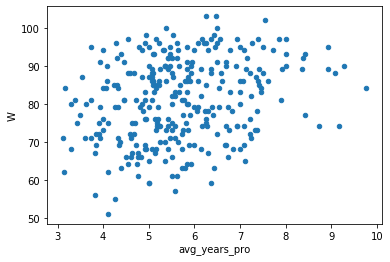

In [20]:
merged.plot.scatter(x="avg_years_pro", y = "W")

In [21]:
#Average years pro impact on runs allowed
model_ayp2 = LinearRegression()
model_ayp2.fit(X = merged[["avg_years_pro"]], y = merged.RA)
print(model_ayp2.score(X = merged[["avg_years_pro"]], y = merged.RA))

0.005534946212427561


In [22]:
#Average bullpen age impact on wins
model_bpage = LinearRegression()
model_bpage.fit(X = merged[["avg_bullpen_age"]], y = merged.W)
print(model_bpage.score(X = merged[["avg_bullpen_age"]], y = merged.W))

0.04731457438601239


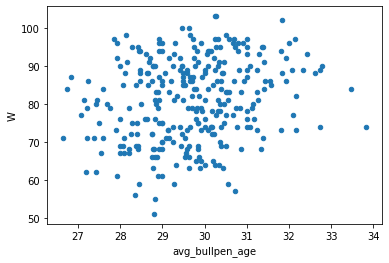

In [23]:
merged.plot.scatter(x="avg_bullpen_age", y = "W")

In [24]:
#Average bullpen age impact on runs allowed
model_bpage2 = LinearRegression()
model_bpage2.fit(X = merged[["avg_bullpen_age"]], y = merged.RA)
print(model_bpage2.score(X = merged[["avg_bullpen_age"]], y = merged.RA))

0.00245236674404703


Age of the bullpen or how may years a pitcher has been in the league does not significantly effect wins or runs allowed. 

---

## Bullpen Attributes

Bullpen attributes can show if the skill level and execution of the bullpen would impact - 1) team wins or 2) runs allowed. This was accomplished by showing how total strikeouts and walk probability of the bullpen impacted ***Wins*** and ***Runs Allowed***:

In [25]:
#Strikeouts by bullpen impact on wins
model_pso = LinearRegression()
model_pso.fit(X = merged[["pitcher_SO"]], y = merged.W)
print(model_pso.score(X = merged[["pitcher_SO"]], y = merged.W))

0.34819917908592624


In [26]:
#Strikeouts by bullpen impact on runs allowed
model_pso2 = LinearRegression()
model_pso2.fit(X = merged[["pitcher_SO"]], y = merged.RA)
print(model_pso2.score(X = merged[["pitcher_SO"]], y = merged.RA))

0.39291283003295885


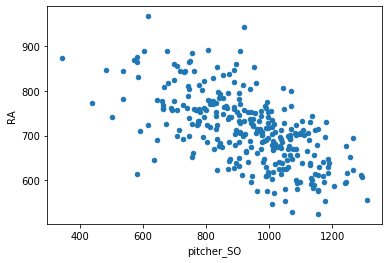

In [27]:
merged.plot.scatter(x = "pitcher_SO", y = "RA")

In [28]:
#Walk probability impact on wins 
model_walk_prob = LinearRegression()
model_walk_prob.fit(X = merged[["walk_prob"]], y = merged.W)
print(model_walk_prob.score(X = merged[["walk_prob"]], y = merged.W))

0.1838530697172749


In [29]:
#Walk probability impact on runs allowed 
model_walk_prob2 = LinearRegression()
model_walk_prob2.fit(X = merged[["walk_prob"]], y = merged.RA)
print(model_walk_prob2.score(X = merged[["walk_prob"]], y = merged.RA))

0.30511370435240004


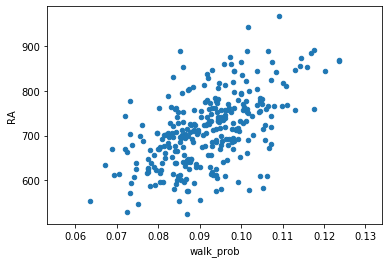

In [30]:
merged.plot.scatter(x="walk_prob", y = "RA")

Out of our three areas of focus, bullpen attributes impacted wins and runs allowed the most. This makes sense as the skill of a pitcher should more directly effect team pitching success. We would want to maximize our pitching bullpen's skill level looking at their attributes and weighing this more important than age or money we constructing a team's pitching bullpen.

---
## Side note: Age Impacting Cost
Look at how player age and number of years in the MLB impact how much a team spent per SO.

In [31]:
#Average Bullpen Age impact on cost per SO
model_bp_age = LinearRegression()
model_bp_age.fit(X = merged[["avg_bullpen_age"]], y = merged.cost_per_SO)
print(model_bp_age.score(X = merged[["avg_bullpen_age"]], y = merged.cost_per_SO))

0.2355652837005756


In [32]:
#Average years pro impact on cost per SO
model_yr_pro = LinearRegression()
model_yr_pro.fit(X = merged[["avg_years_pro"]], y = merged.cost_per_SO)
print(model_yr_pro.score(X = merged[["avg_years_pro"]], y = merged.cost_per_SO))

0.3021838339886884


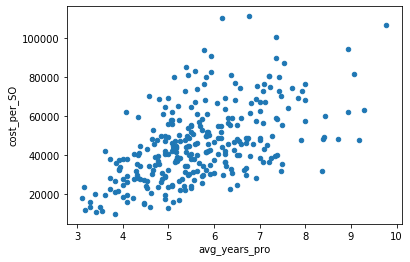

In [33]:
merged.plot.scatter(x="avg_years_pro", y = "cost_per_SO")

The older the player and the longer he has been in the league shows a slight correlation to how much is spent on that player. This makes sense as most player contracts are structured to give a player more money as he reaches his "prime years" - which should be later on in his career. We would want to minimize the years a player has been in the league to save cost on our pitching bullpen.

---

# Conclusion

1. Does the amount a GM pays their bullpen or how much they spend per strikeout help their team win? 
   - **Salary** and **cost_per_SO** weren't strong deciders of **Wins** and **RA**.


2. Does an older bullpen lead to more wins or less runs allowed?
   - No correlation was found between the **avg_bullpen_age** or **avg_career_age** and how they impact **Wins** and **RA**.


3. Does a bullpen that throws more strikeouts and throws less walks on average lead to more wins or less runs allowed?
   - There was a noticable determinant between **strikeouts** thrown by the bullpen and the **walk_prob** of the bullpen and how they impact **Wins** and **RA**.
   

4. It was also found that an older bullpen (higher **avg_career_age** and higher **avg_bullpen_age**) could lead to more money a team spent per strikeout.

---


With these findings, we can conclude that the greater age of bullpen and more money spent on the bullpen did not lead a team to more wins and less runs allowed - metrics that drive "success" in the MLB. However, the total strikouts a bullpen pitched and the less walks they threw did impact the number of wins the team had and the number of runs the bullpen allowed.

With this, we would want to find a young bullpen (minimizing cost spent per strikout) that threw the most strikouts and threw the least amount of walks on average.


